In [9]:
import torch
from pytorch_pretrained_biggan import (
    BigGAN,
    truncated_noise_sample,
    one_hot_from_int
)
import PIL.Image
import numpy as np
import os
import argparse
from tqdm import tqdm
import json
import pickle
import matplotlib.pyplot as plt

In [14]:
def convert_to_images(obj):
    """ Convert an output tensor from BigGAN in a list of images.
    """
    # need to fix import, see: https://github.com/huggingface/pytorch-pretrained-BigGAN/pull/14/commits/68a7446951f0b9400ebc7baf466ccc48cdf1b14c
    if not isinstance(obj, np.ndarray):
        obj = obj.detach().numpy()
    obj = obj.transpose((0, 2, 3, 1))
    obj = np.clip(((obj + 1) / 2.0) * 256, 0, 255)
    img = []
    for i, out in enumerate(obj):
        out_array = np.asarray(np.uint8(out), dtype=np.uint8)
        img.append(PIL.Image.fromarray(out_array))
    return img

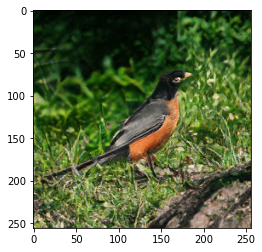

In [35]:
seed = 0
truncation = 1.0
idx = 15
nimg = 1
class_vector = one_hot_from_int(idx, batch_size=nimg)
noise_vector = truncated_noise_sample(truncation=truncation,
                                      batch_size=nimg,
                                      seed=seed)
class_vector = torch.from_numpy(class_vector).cuda()
noise_vector = torch.from_numpy(noise_vector).cuda()
with torch.no_grad():
    output = model(noise_vector, class_vector, truncation=truncation)
output = output.cpu()
ims = convert_to_images(output)
plt.imshow(np.array(ims[0]))

image from z in z_dataset
image on disk


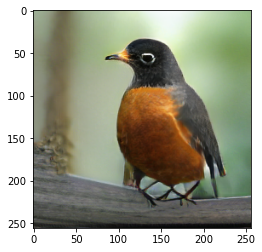

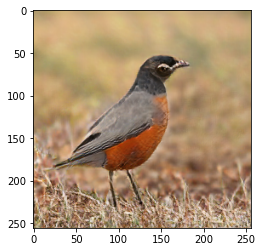

In [44]:
path = '/data/vision/phillipi/ganclr/datasets/big_deep256_tr1.0_gauss1_std1.0_imagenet100_N20/train/n01558993'
with open(os.path.join(path,'z_dataset.pkl'), 'rb') as fid:
    z_dict = pickle.load(fid)
im_name = 'seed0015_sample00650_anchor.png'
z_vect = z_dict[im_name][0]

with torch.no_grad():
    output = model(torch.from_numpy(np.expand_dims(z_vect, axis=0)).cuda(), class_vector, truncation=truncation)
output = output.cpu()
ims = convert_to_images(output)
print('image from z in z_dataset')
plt.figure()
plt.imshow(np.array(ims[0]))
print('image on disk')
im_disk = PIL.Image.open(os.path.join(path, im_name))
plt.figure()
plt.imshow(im_disk)

image from z in z_dataset
image on disk


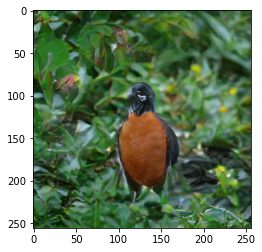

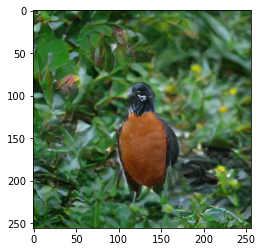

In [43]:
## The following code shows z_dataset is not qutie right (order is not correct)
im_name = 'seed0015_sample00000_anchor.png'
z_vect = z_dict[im_name][0]
with torch.no_grad():
    output = model(torch.from_numpy(np.expand_dims(z_vect, axis=0)).cuda(), class_vector, truncation=truncation)
output = output.cpu()
ims = convert_to_images(output)
print('image from z in z_dataset')
plt.figure()
plt.imshow(np.array(ims[0]))
print('image on disk')
im_disk = PIL.Image.open(os.path.join(path, im_name))
plt.figure()
plt.imshow(im_disk)